In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# 目的
遺伝子学的分類に基づいた、予後の2値分類を実施する。  
分類はCLAUDIN_SUBTYPEに基づいて実施。  
予後は5年、10年、15年の3つの年次に分けている。Trueで死亡であることに注意すること。

# データ読み込み
読み込み元：
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/claudin_subtype_chi2"

サブタイプ毎のデータを使用

データの種類が多いので、辞書型で表現する  

In [2]:
# ディレクトリ構造を辞書に反映するための関数
def dir2dict(dic, path):
    for k in os.listdir(path):
        if os.path.isdir(os.path.join(path, k)):
            if not k in dic:
                dic[k] = dict()
            dir2dict(dic[k], path + "/" + k)
        else:
            if k[0] == "X" or k[0] == "y":
                dic[k.split(".")[0]] = pd.read_pickle(path + "/" + k)

In [3]:
df_dict = dict()
dir2dict(df_dict, config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR)

**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**
**create dict**


# モデルのトレーニング

## データ全体のベースライン・学習

### boruta適用データのベースライン・基本学習結果

In [19]:
for year in range(5, 16, 5):  # 予後年数毎のループ

    X_train_tmp = df_dict["chi2"]["boruta"]["train"]["X{0:0=2}".format(year)]
    y_train_tmp = df_dict["chi2"]["boruta"]["train"]["y{0:0=2}".format(year)]
    X_test_tmp = df_dict["chi2"]["boruta"]["test"]["X{0:0=2}".format(year)]
    y_test_tmp = df_dict["chi2"]["boruta"]["test"]["y{0:0=2}".format(year)]
    assert X_train_tmp.shape[0] == y_train_tmp.shape[0], "train size is incorrect"
    assert X_test_tmp.shape[0] == y_test_tmp.shape[0], "test size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train_tmp, np.zeros(len(y_train_tmp))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train_tmp, np.zeros(len(y_train_tmp))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train_tmp, np.ones(len(y_train_tmp))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train_tmp.columns)
    print("学習サンプルサイズ：", X_train_tmp.shape)
    display("ラベル比率：", y_train_tmp.value_counts())
    display(compare_bcms(X_train_tmp, y_train_tmp))

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.812)
使用特徴量： Index(['BCL2', 'C1orf106', 'C6orf97', 'CDCA5', 'ESR1', 'FAM83D', 'FGD3',
       'FGFR4', 'HPN', 'IL6ST', 'KIF20A', 'KRT80', 'MAPT', 'PREX1', 'SERPINA3',
       'SUSD3', 'TMEM26'],
      dtype='object')
学習サンプルサイズ： (1306, 17)


'ラベル比率：'

0    1060
1     246
Name: OS_05years, dtype: int64

11it [00:19,  1.81s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.724604,0.722842,0.465884,0.461608
Quadratic Discriminant Analysis,0.779480,0.743500,0.461649,0.362645
Decision Tree,0.862259,0.777962,0.561068,0.303796
AdaBoost,0.856474,0.791762,0.497034,0.267242
Nearest Neighbors,0.834950,0.774839,0.412885,0.204478
Random Forest,0.842607,0.811638,0.299490,0.120025
Logistic Regression,0.817083,0.807798,0.168097,0.117837
Polynomial SVM,0.836736,0.801668,0.292165,0.112282
Linear SVM,0.811639,0.811650,0.000000,0.000000


----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.636)
使用特徴量： Index(['ATHL1', 'AURKA', 'BCL2', 'CCNB2', 'CDC20', 'CDCA5', 'CLIC6', 'FAM83D',
       'FGD3', 'FGFR4', 'GRB7', 'HIST1H4H', 'KIF20A', 'KRT80', 'LRP2', 'MAPT',
       'NAT1', 'PRC1', 'PTTG1', 'SERPINA1', 'SPATA18', 'STC2', 'SUSD3',
       'TMEM26', 'TPX2', 'TROAP', 'UBE2C', 'UHRF1'],
      dtype='object')
学習サンプルサイズ： (1048, 28)


'ラベル比率：'

0    667
1    381
Name: OS_10years, dtype: int64

11it [00:19,  1.80s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.644402,0.643104,0.567516,0.561035
Quadratic Discriminant Analysis,0.747773,0.642179,0.654201,0.506154
Polynomial SVM,0.862913,0.631648,0.800610,0.476319
Random Forest,0.830683,0.684084,0.728795,0.463868
Logistic Regression,0.686492,0.669826,0.493618,0.460273
Nearest Neighbors,0.747774,0.623132,0.632470,0.453031
RBF SVM,0.729219,0.675495,0.546494,0.451828
AdaBoost,0.783396,0.643141,0.676218,0.445716
Decision Tree,0.791454,0.611630,0.697162,0.435997


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['ADH1A', 'AURKA', 'CCL19', 'CIDEC', 'CLEC3A', 'CLIC6', 'CYP4F22',
       'DARC', 'FGD3', 'HIST1H4H', 'LOC389033', 'MAPT', 'MYBPC1', 'NAT1',
       'PLIN4', 'S100P', 'SERPINA3', 'SFRP1', 'SPP1', 'SUSD3', 'TAT', 'TMEM26',
       'UBE2C', 'VTCN1'],
      dtype='object')
学習サンプルサイズ： (811, 24)


'ラベル比率：'

1    432
0    379
Name: OS_15years, dtype: int64

11it [00:06,  1.65it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,0.805178,0.648600,0.827197,0.693007
Sigmoid SVM,0.532677,0.532746,0.695061,0.692588
Logistic Regression,0.681463,0.653538,0.713046,0.685153
RBF SVM,0.732840,0.631376,0.771050,0.684095
Linear SVM,0.679272,0.643662,0.712769,0.679384
Naive Bayes,0.645979,0.637519,0.684621,0.672273
AdaBoost,0.801616,0.628907,0.817259,0.657972
Nearest Neighbors,0.742431,0.615342,0.773608,0.657555
Quadratic Discriminant Analysis,0.734346,0.601762,0.767062,0.646239


## subtype毎のベースライン・学習

### borutaを使用した場合のベースライン・基本学習結果

In [5]:
pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)["CLAUDIN_SUBTYPE"].unique()

array(['claudin-low', 'LumA', 'LumB', 'Her2', 'Normal', 'Basal'],
      dtype=object)

In [24]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for subtype in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        X_train_tmp = df_dict["chi2"]["claudin_subtype"]["train"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_train_tmp = df_dict["chi2"]["claudin_subtype"]["train"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        X_test_tmp = df_dict["chi2"]["claudin_subtype"]["test"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_test_tmp = df_dict["chi2"]["claudin_subtype"]["test"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        assert X_train_tmp.shape[0] == y_train_tmp.shape[0], "train size is incorrect"
        assert X_test_tmp.shape[0] == y_test_tmp.shape[0], "test size is incorrect"

        # accuracyの表示
        print("----------" * 10)
        print("subtype: ", subtype)
        print("予後年数：{0:0=2}年:".format(year))
        if accuracy_score(y_train_tmp, np.zeros(len(y_train_tmp))) >= 0.5:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train_tmp, np.zeros(len(y_train_tmp))), 3),
            )
        else:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train_tmp, np.ones(len(y_train_tmp))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train_tmp.columns)
        print("学習サンプルサイズ：", X_train_tmp.shape)
        display("ラベル比率：", y_train_tmp.value_counts())
        display(compare_bcms(X_train_tmp, y_train_tmp))

=====05=====05=====05=====05=====05=====05=====05=====05=====05=====05
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：05年:
accuracyベースライン： ('0>1', 0.812)
使用特徴量： Index(['CT45A6', 'SOX11', 'SFRP1', 'C4orf7', 'CLCA2', 'GABRP', 'S100A9',
       'SNAR-A3'],
      dtype='object')
学習サンプルサイズ： (138, 8)


'ラベル比率：'

0    112
1     26
Name: OS_05years, dtype: int64

11it [00:01, 10.52it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.847826,0.825824,0.554174,0.446667
AdaBoost,1.000000,0.819780,1.000000,0.339048
Quadratic Discriminant Analysis,0.875206,0.818132,0.614816,0.303333
Nearest Neighbors,0.864748,0.812088,0.516862,0.273333
Linear SVM,0.845413,0.834066,0.406932,0.236667
Logistic Regression,0.841381,0.812088,0.462563,0.216667
Polynomial SVM,0.939613,0.759341,0.815806,0.213333
RBF SVM,0.879206,0.812088,0.527113,0.170000
Decision Tree,0.834948,0.768681,0.389799,0.028571


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：05年:
accuracyベースライン： ('0>1', 0.923)
使用特徴量： Index(['S100P', 'SLC30A8', 'CPB1'], dtype='object')
学習サンプルサイズ： (466, 3)


'ラベル比率：'

0    430
1     36
Name: OS_05years, dtype: int64

11it [00:22,  2.06s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.901044,0.894820,0.110757,0.098333
Nearest Neighbors,0.924652,0.924699,0.128020,0.050000
AdaBoost,0.942537,0.907539,0.438028,0.025000
Quadratic Discriminant Analysis,0.908199,0.903469,0.058005,0.025000
Decision Tree,0.922745,0.922618,0.000000,0.000000
Linear SVM,0.922745,0.922618,0.000000,0.000000
Logistic Regression,0.922745,0.922618,0.000000,0.000000
Polynomial SVM,0.922745,0.922618,0.000000,0.000000
RBF SVM,0.922745,0.922618,0.000000,0.000000


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：05年:
accuracyベースライン： ('0>1', 0.788)
使用特徴量： Index(['SCGB2A2', 'TMEM26', 'BAMBI', 'AGTR1', 'ANKRD30A', 'TPSG1', 'TFAP2B',
       'IGLL1_1', 'FBN2', 'KCNK1', 'BEX1', 'GP2', 'IGKC', 'GRIA2', 'SCGB2A1',
       'DB005376', 'IGHG1', 'SCGB1D2', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (306, 19)


'ラベル比率：'

0    241
1     65
Name: OS_05years, dtype: int64

11it [00:01,  6.00it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.739277,0.717527,0.533940,0.498267
Polynomial SVM,0.943718,0.738387,0.860710,0.382452
AdaBoost,0.977484,0.754516,0.946663,0.353967
Logistic Regression,0.811540,0.770753,0.442618,0.306542
Quadratic Discriminant Analysis,0.883805,0.718172,0.764582,0.283286
Nearest Neighbors,0.811908,0.738280,0.480811,0.246396
Decision Tree,0.845679,0.708387,0.612867,0.236465
Linear SVM,0.816265,0.741720,0.437350,0.205143
RBF SVM,0.793382,0.787419,0.053450,0.000000


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：05年:
accuracyベースライン： ('0>1', 0.667)
使用特徴量： Index(['KRT81', 'CLIC6', 'GFRA1', 'GRPR', 'U79293', 'CLCA2', 'SUSD3', 'SCUBE2',
       'AGR3', 'CALML5', 'ESR1'],
      dtype='object')
学習サンプルサイズ： (153, 11)


'ラベル比率：'

0    102
1     51
Name: OS_05years, dtype: int64

11it [00:01,  8.48it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.639813,0.635000,0.590706,0.578428
Quadratic Discriminant Analysis,0.718243,0.602917,0.650743,0.490699
Decision Tree,0.782186,0.688333,0.643864,0.470108
Nearest Neighbors,0.725484,0.640833,0.583056,0.400842
Logistic Regression,0.695753,0.642500,0.441498,0.373724
AdaBoost,0.996377,0.627500,0.994845,0.347006
Polynomial SVM,0.874368,0.542917,0.803389,0.277981
RBF SVM,0.727668,0.667500,0.409309,0.212381
Random Forest,0.780694,0.628750,0.551334,0.198571


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：05年:
accuracyベースライン： ('0>1', 0.821)
使用特徴量： Index(['CST1', 'FABP7', 'CPB1', 'AGR3', 'CALML5', 'ESR1', 'CFB'], dtype='object')
学習サンプルサイズ： (95, 7)


'ラベル比率：'

0    78
1    17
Name: OS_05years, dtype: int64

11it [00:01,  9.95it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.875964,0.826667,0.662702,0.416667
AdaBoost,1.000000,0.786667,1.000000,0.308571
Linear SVM,0.863078,0.837778,0.486434,0.295238
Nearest Neighbors,0.851409,0.826667,0.409420,0.245238
Polynomial SVM,0.921614,0.787778,0.714561,0.240000
Quadratic Discriminant Analysis,0.859590,0.797778,0.609841,0.233333
Logistic Regression,0.870137,0.825556,0.546332,0.216667
RBF SVM,0.865431,0.815556,0.426600,0.100000
Decision Tree,0.822161,0.816667,0.059259,0.000000


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：05年:
accuracyベースライン： ('0>1', 0.655)
使用特徴量： Index(['IGHG1', 'IGKC', 'CSN3', 'SCGB2A2', 'CXCL13'], dtype='object')
学習サンプルサイズ： (148, 5)


'ラベル比率：'

0    97
1    51
Name: OS_05years, dtype: int64

11it [00:01,  9.97it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.712451,0.693333,0.606697,0.568236
Quadratic Discriminant Analysis,0.714718,0.653333,0.616742,0.518362
Logistic Regression,0.722220,0.701905,0.554861,0.503080
Linear SVM,0.731259,0.675238,0.575733,0.480144
Polynomial SVM,0.743991,0.612381,0.612688,0.436768
Decision Tree,0.760498,0.619524,0.627137,0.382463
AdaBoost,0.945910,0.607619,0.918676,0.381962
Random Forest,0.752991,0.612381,0.571293,0.331356
Nearest Neighbors,0.765004,0.586190,0.619039,0.299846


=====10=====10=====10=====10=====10=====10=====10=====10=====10=====10
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：10年:
accuracyベースライン： ('0>1', 0.692)
使用特徴量： Index(['PROM1', 'ELF5', 'SOX10', 'KRT15', 'ROPN1', 'SFRP1', 'C4orf7', 'GABRP',
       'KRT14', 'S100A7', 'ROPN1B', 'SNAR-A3', 'MYBPC1'],
      dtype='object')
学習サンプルサイズ： (107, 13)


'ラベル比率：'

0    74
1    33
Name: OS_10years, dtype: int64

11it [00:01,  8.09it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.661458,0.626364,0.583516,0.506486
Polynomial SVM,0.915904,0.726364,0.843508,0.432857
Logistic Regression,0.797476,0.719091,0.628586,0.424286
Nearest Neighbors,0.789218,0.700909,0.601403,0.408571
RBF SVM,0.812038,0.736364,0.591425,0.363810
Decision Tree,0.788187,0.665455,0.619779,0.355952
Quadratic Discriminant Analysis,0.858741,0.652727,0.787070,0.342222
Linear SVM,0.801665,0.717273,0.578724,0.338730
AdaBoost,1.000000,0.635455,1.000000,0.328333


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：10年:
accuracyベースライン： ('0>1', 0.783)
使用特徴量： Index(['IGJ', 'MKX', 'PGR', 'CPB1', 'VTCN1', 'GLA', 'CLIC6', 'SUSD3', 'C8orf4',
       'C6orf126', 'BEX1', 'PVALB', 'NFKBIZ', 'GRIA2', 'CLEC3A', 'SLC30A8',
       'PROM1', 'S100P', 'KRT15', 'ZIC2', 'SLC7A2', 'PTHLH', 'CNKSR3',
       'MYBPC1'],
      dtype='object')
学習サンプルサイズ： (359, 24)


'ラベル比率：'

0    281
1     78
Name: OS_10years, dtype: int64

11it [00:02,  5.49it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.743114,0.721508,0.555373,0.489598
Quadratic Discriminant Analysis,0.898174,0.746508,0.790011,0.369782
Polynomial SVM,0.990716,0.713095,0.978178,0.354479
Decision Tree,0.838135,0.766270,0.539427,0.352757
Linear SVM,0.817701,0.782857,0.444996,0.318252
Logistic Regression,0.808730,0.755079,0.458758,0.317346
Nearest Neighbors,0.850199,0.763492,0.579077,0.259038
AdaBoost,0.959766,0.735556,0.901827,0.248907
Random Forest,0.805014,0.782857,0.183061,0.033333


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：10年:
accuracyベースライン： ('0>1', 0.54)
使用特徴量： Index(['SERPINA1', 'IGKC', 'CLIC6', 'TUBA3D', 'PI15', 'DIO1', 'CBLN2',
       'FAM198B', 'SHISA2', 'TFAP2B'],
      dtype='object')
学習サンプルサイズ： (252, 10)


'ラベル比率：'

0    136
1    116
Name: OS_10years, dtype: int64

11it [00:01,  7.25it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.649914,0.615692,0.646911,0.609369
Logistic Regression,0.656534,0.639385,0.615417,0.588292
Linear SVM,0.665348,0.631231,0.635247,0.587555
Quadratic Discriminant Analysis,0.684295,0.608154,0.680018,0.587028
Decision Tree,0.763231,0.639231,0.738759,0.576775
Random Forest,0.776024,0.627846,0.747551,0.569239
Polynomial SVM,0.793647,0.583538,0.783803,0.557542
Nearest Neighbors,0.718699,0.564154,0.687676,0.543702
RBF SVM,0.718249,0.596000,0.685456,0.530334


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：10年:
accuracyベースライン： ('0>1', 0.558)
使用特徴量： Index(['SPP1', 'ESR1', 'S100A8', 'GFRA1', 'U79293', 'CA12', 'SCUBE2',
       'SERPINA5', 'C19orf33', 'CLDN8', 'S100A9', 'SERHL2', 'CALML5', 'ATHL1',
       'LUM', 'FAR2P2', 'CLCA2', 'CAPN8', 'TSC22D1', 'SERPINA3', 'RGS11',
       'HIST1H4H', 'PGK1', 'SPINK8'],
      dtype='object')
学習サンプルサイズ： (129, 24)


'ラベル比率：'

1    72
0    57
Name: OS_10years, dtype: int64

11it [00:01,  8.94it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,0.755401,0.675000,0.795527,0.733947
Naive Bayes,0.693376,0.675641,0.735917,0.718585
Sigmoid SVM,0.558134,0.557692,0.716317,0.708039
RBF SVM,0.770056,0.628846,0.811534,0.701830
Nearest Neighbors,0.706329,0.598077,0.747829,0.654218
Decision Tree,0.745034,0.644231,0.771752,0.653791
AdaBoost,1.000000,0.550000,1.000000,0.603061
Quadratic Discriminant Analysis,0.965532,0.511538,0.969449,0.599365
Linear SVM,0.748490,0.535897,0.790630,0.593815


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：10年:
accuracyベースライン： ('0>1', 0.646)
使用特徴量： Index(['UGT2B11', 'TCN1', 'UGT2B7', 'LOC389033', 'CLIC6', 'SCGB3A1', 'HMGCS2',
       'SNAR-A3', 'SUSD3'],
      dtype='object')
学習サンプルサイズ： (79, 9)


'ラベル比率：'

0    51
1    28
Name: OS_10years, dtype: int64

11it [00:00, 11.27it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.800293,0.748214,0.726814,0.594524
RBF SVM,0.846694,0.773214,0.740412,0.550000
Quadratic Discriminant Analysis,0.888908,0.696429,0.845791,0.535714
Nearest Neighbors,0.821362,0.758929,0.719163,0.509048
Logistic Regression,0.820012,0.685714,0.728831,0.495476
Polynomial SVM,0.964847,0.608929,0.948057,0.491111
AdaBoost,1.000000,0.621429,1.000000,0.490000
Linear SVM,0.827034,0.673214,0.746736,0.465476
Decision Tree,0.786248,0.633929,0.697615,0.433333


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：10年:
accuracyベースライン： ('0>1', 0.557)
使用特徴量： Index(['TFF3', 'IGHG1', 'S100A8', 'SCGB2A2', 'CSN3', 'GZMB', 'CXCL13',
       'C4orf7', 'UBD', 'KRT14', 'IGKC', 'S100A9', 'CA9'],
      dtype='object')
学習サンプルサイズ： (122, 13)


'ラベル比率：'

0    68
1    54
Name: OS_10years, dtype: int64

11it [00:01, 10.36it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.745880,0.704487,0.717849,0.657248
RBF SVM,0.821526,0.697436,0.789965,0.642637
Linear SVM,0.788732,0.713462,0.756560,0.630708
Logistic Regression,0.776906,0.689103,0.744590,0.612454
Random Forest,0.760475,0.646795,0.716756,0.555302
Nearest Neighbors,0.805113,0.635256,0.770882,0.535938
Polynomial SVM,0.923495,0.624359,0.909298,0.527637
Decision Tree,0.752285,0.589103,0.704666,0.509307
Quadratic Discriminant Analysis,0.873428,0.582051,0.850914,0.483521


=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.575)
使用特徴量： Index(['SERPINA3', 'PROM1', 'ELF5', 'SOX10', 'KRT15', 'ROPN1', 'SFRP1',
       'C4orf7', 'GABRP', 'KRT14', 'STC2', 'ROPN1B'],
      dtype='object')
学習サンプルサイズ： (80, 12)


'ラベル比率：'

0    46
1    34
Name: OS_15years, dtype: int64

11it [00:01, 10.87it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Quadratic Discriminant Analysis,0.890278,0.7625,0.870303,0.570823
Naive Bayes,0.702778,0.6750,0.677535,0.551486
RBF SVM,0.812500,0.7500,0.759739,0.549444
Random Forest,0.734722,0.6625,0.703092,0.540433
Nearest Neighbors,0.790278,0.7000,0.747327,0.532222
Polynomial SVM,0.929167,0.6750,0.918953,0.527569
AdaBoost,1.000000,0.6875,1.000000,0.516032
Linear SVM,0.809722,0.7250,0.753051,0.477937
Logistic Regression,0.780556,0.6875,0.717860,0.477222


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.626)
使用特徴量： Index(['BEX1', 'S100P', 'DB005376', 'SLC30A8', 'ZIC2', 'RPS25', 'CLEC3A',
       'CLIC6', 'MKX', 'GRIA2', 'CYP4F22', 'C8orf4', 'MYBPC1', 'VTCN1'],
      dtype='object')
学習サンプルサイズ： (270, 14)


'ラベル比率：'

0    169
1    101
Name: OS_15years, dtype: int64

11it [00:01,  7.37it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.702058,0.685185,0.633388,0.606979
Logistic Regression,0.747737,0.714815,0.628525,0.578877
Linear SVM,0.742387,0.700000,0.618987,0.567276
Quadratic Discriminant Analysis,0.791358,0.655556,0.728428,0.541160
Nearest Neighbors,0.756379,0.674074,0.654314,0.513381
RBF SVM,0.798354,0.674074,0.702899,0.494395
Random Forest,0.790947,0.674074,0.667111,0.448775
AdaBoost,0.923457,0.618519,0.894836,0.447293
Polynomial SVM,0.905761,0.625926,0.867261,0.444420


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.675)
使用特徴量： Index(['FCRLB', 'CXCL9', 'KISS1R', 'S100A8', 'IGKC', 'TAT', 'PI15', 'CELSR2',
       'DIO1', 'ATP6V1B1', 'CBLN2', 'CAPN8', 'SHISA2', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (194, 14)


'ラベル比率：'

1    131
0     63
Name: OS_15years, dtype: int64

11it [00:01,  8.33it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.794397,0.752895,0.856886,0.821075
Random Forest,0.817885,0.712105,0.879325,0.812314
Logistic Regression,0.787524,0.737105,0.851887,0.809489
Naive Bayes,0.778933,0.747632,0.835369,0.808466
Sigmoid SVM,0.675264,0.675789,0.806105,0.802144
RBF SVM,0.815586,0.706053,0.875283,0.795592
Quadratic Discriminant Analysis,0.819603,0.691842,0.870290,0.774508
Nearest Neighbors,0.761780,0.660263,0.833248,0.762959
AdaBoost,0.983961,0.671053,0.988351,0.755270


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.684)
使用特徴量： Index(['GLYATL2'], dtype='object')
学習サンプルサイズ： (114, 1)


'ラベル比率：'

1    78
0    36
Name: OS_15years, dtype: int64

11it [00:05,  1.96it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Linear SVM,0.684190,0.682576,0.812352,0.800045
Naive Bayes,0.684190,0.682576,0.812352,0.800045
Polynomial SVM,0.684190,0.682576,0.812352,0.800045
Quadratic Discriminant Analysis,0.684190,0.682576,0.812352,0.800045
RBF SVM,0.684190,0.682576,0.812352,0.800045
Random Forest,0.684190,0.682576,0.812352,0.800045
Sigmoid SVM,0.684190,0.682576,0.812352,0.800045
Logistic Regression,0.685170,0.657576,0.811267,0.784393
AdaBoost,0.875243,0.644697,0.914135,0.744959


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.571)
使用特徴量： Index(['LOC389033', 'CLIC6', 'SCGB3A1', 'SNAR-A3', 'CALML5', 'CLEC3A'], dtype='object')
学習サンプルサイズ： (56, 6)


'ラベル比率：'

1    32
0    24
Name: OS_15years, dtype: int64

11it [00:00, 12.14it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
AdaBoost,1.000000,0.826667,1.000000,0.837778
Polynomial SVM,0.966235,0.800000,0.970563,0.806270
Quadratic Discriminant Analysis,0.859176,0.823333,0.868622,0.795714
Naive Bayes,0.819451,0.806667,0.840498,0.776825
Logistic Regression,0.875059,0.776667,0.888838,0.761270
Linear SVM,0.892902,0.776667,0.904502,0.754127
RBF SVM,0.874824,0.770000,0.878207,0.748651
Nearest Neighbors,0.847137,0.753333,0.857262,0.740476
Random Forest,0.746157,0.606667,0.808384,0.707937


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.577)
使用特徴量： Index(['IGHG1', 'S100A8', 'IGKC', 'CXCL13', 'S100A9'], dtype='object')
学習サンプルサイズ： (97, 5)


'ラベル比率：'

1    56
0    41
Name: OS_15years, dtype: int64

11it [00:01, 10.36it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Random Forest,0.764015,0.697778,0.805851,0.728916
Naive Bayes,0.713610,0.688889,0.752211,0.701170
Quadratic Discriminant Analysis,0.753696,0.678889,0.802238,0.699665
Sigmoid SVM,0.577260,0.572222,0.731687,0.696954
Linear SVM,0.707850,0.644444,0.767234,0.685424
Logistic Regression,0.720494,0.635556,0.773366,0.674402
Polynomial SVM,0.781204,0.627778,0.825534,0.662544
Decision Tree,0.725052,0.625556,0.762070,0.650443
Nearest Neighbors,0.752521,0.584444,0.803261,0.644205


# 予測・最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

## optuna

モデルのパラメータをベイズ最適化に基づいて最適化していくoptunaを使用する

### Random Forest


In [32]:
def objective(trial):
    # ランダムフォレストのパラメータチューニング
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 50, log=True)
    max_leaf_noddes = trial.suggest_int("max_leaf_nodes", 2, 100)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_noddes,
        max_features=max_features,
        random_state=SEED,
    )
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=10, scoring=make_scorer(f1_score))
    accuracy = score.mean()
    return accuracy

##　全サンプルでの予測(boruta)

In [33]:
year = 15
X_train_tmp = df_dict["chi2"]["boruta"]["train"]["X{0:0=2}".format(year)]
y_train_tmp = df_dict["chi2"]["boruta"]["train"]["y{0:0=2}".format(year)]
X_test_tmp = df_dict["chi2"]["boruta"]["test"]["X{0:0=2}".format(year)]
y_test_tmp = df_dict["chi2"]["boruta"]["test"]["y{0:0=2}".format(year)]

X, y = X_train_tmp.copy(), y_train_tmp.copy()
study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

[I 2022-08-07 15:22:17,919] A new study created in memory with name: no-name-63a3944c-5417-4d34-9457-b33c0d4ea1e8
[I 2022-08-07 15:22:19,205] Trial 0 finished with value: 0.7115116262326916 and parameters: {'n_estimators': 548, 'criterion': 'log_loss', 'max_depth': 2, 'max_leaf_nodes': 14, 'max_features': 'log2'}. Best is trial 0 with value: 0.7115116262326916.
[I 2022-08-07 15:22:20,389] Trial 1 finished with value: 0.7120913398162949 and parameters: {'n_estimators': 579, 'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 23, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7120913398162949.
[I 2022-08-07 15:22:23,758] Trial 2 finished with value: 0.7061753812485729 and parameters: {'n_estimators': 818, 'criterion': 'log_loss', 'max_depth': 27, 'max_leaf_nodes': 35, 'max_features': 'log2'}. Best is trial 1 with value: 0.7120913398162949.
[I 2022-08-07 15:22:26,178] Trial 3 finished with value: 0.701314395179744 and parameters: {'n_estimators': 260, 'criterion': 'gini', 'max_

In [34]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

The best value is : 
 0.7162384310291756
The best parameters are : 
 {'n_estimators': 705, 'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 13, 'max_features': 'log2'}


In [35]:
print("tuning前")
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train_tmp, y_train_tmp)
pred_tmp = rf.predict(X_test_tmp)
show_scores(y_test_tmp, pred_tmp)

print("tuning後")
rf = RandomForestClassifier(
    n_estimators=705,
    criterion="entropy",
    max_depth=2,
    max_leaf_nodes=13,
    max_features="log2",
    random_state=SEED,
)
rf.fit(X_train_tmp, y_train_tmp)
pred_tmp = rf.predict(X_test_tmp)
show_scores(y_test_tmp, pred_tmp)

tuning前
accuracy:  0.6201550387596899
precision:  0.625
recall:  0.7246376811594203
f1 score:  0.6711409395973154
tuning後
accuracy:  0.6782945736434108
precision:  0.655367231638418
recall:  0.8405797101449275
f1 score:  0.7365079365079366


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



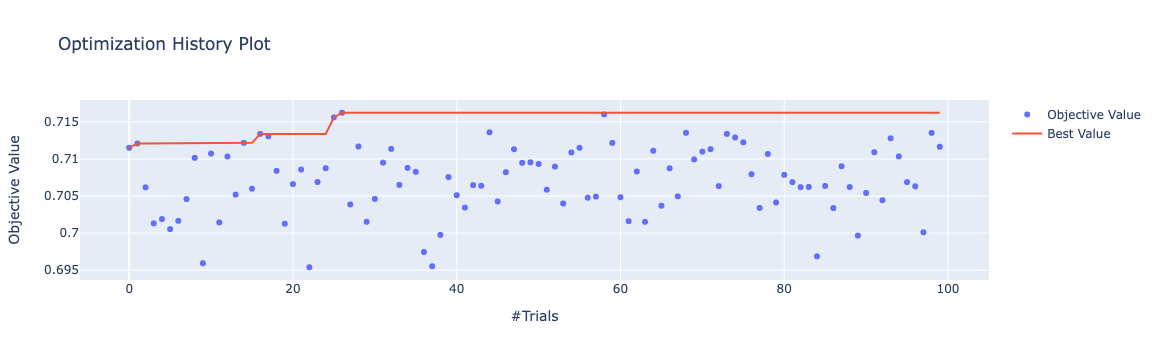

In [37]:
# optunaの過程を可視化
optuna.visualization.plot_optimization_history(study).show()

## subtype毎の予測

In [39]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for subtype in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        print("-----" * 10)
        print(subtype)
        X_train_tmp = df_dict["chi2"]["claudin_subtype"]["train"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_train_tmp = df_dict["chi2"]["claudin_subtype"]["train"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        X_test_tmp = df_dict["chi2"]["claudin_subtype"]["test"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_test_tmp = df_dict["chi2"]["claudin_subtype"]["test"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        assert X_train_tmp.shape[0] == y_train_tmp.shape[0], "train size is incorrect"
        assert X_test_tmp.shape[0] == y_test_tmp.shape[0], "test size is incorrect"

        print("tuning前")
        rf = RandomForestClassifier(random_state=SEED)
        rf.fit(X_train_tmp, y_train_tmp)
        pred_tmp = rf.predict(X_test_tmp)
        show_scores(y_test_tmp, pred_tmp)

        print("tuning後")
        rf = RandomForestClassifier(
            n_estimators=705,
            criterion="entropy",
            max_depth=2,
            max_leaf_nodes=13,
            max_features="log2",
            random_state=SEED,
        )
        rf.fit(X_train_tmp, y_train_tmp)
        pred_tmp = rf.predict(X_test_tmp)
        show_scores(y_test_tmp, pred_tmp)

=====05=====05=====05=====05=====05=====05=====05=====05=====05=====05
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.7954545454545454
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後
accuracy:  0.8181818181818182
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumA
tuning前
accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumB
tuning前
accuracy:  0.8260869565217391
precision:  0.3333333333333333
recall:  0.05263157894736842
f1 score:  0.09090909090909091
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy:  0.8347826086956521
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
Her2
tuning前
accuracy:  0.7450980392156863
precision:  0.7272727272727273
recall:  0.4444444444444444
f1 score:  0.5517241379310345
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy:  0.6274509803921569
precision:  0.4
recall:  0.1111111111111111
f1 score:  0.1739130434782609
--------------------------------------------------
Normal
tuning前
accuracy:  0.7714285714285715
precision:  0.25
recall:  0.5
f1 score:  0.3333333333333333
tuning後
accuracy:  0.7428571428571429
precision:  0.14285714285714285
recall:  0.25
f1 score:  0.18181818181818182
--------------------------------------------------
Basal
tuning前
accuracy:  0.42857142857142855
precision:  0.2727272727272727
recall:  0.15789473684210525
f1 score:  0.19999999999999998
tuning後
accuracy:  0.47619047619047616
precision:  0.2857142857142857
recall:  0.10526315789473684
f1 score:  0.15384615384615385
=====10=====10=====10=====10=====10=====10=====10=====10=====10=====10
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.5714285714285714
precision:  0.2857142857142857
recall:  0.16666666666666666
f1 score:  0.2105263157894737
tuning後
accuracy:  0.6571428571428571
precisio

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



accuracy:  0.6236559139784946
precision:  0.4166666666666667
recall:  0.3225806451612903
f1 score:  0.3636363636363636
--------------------------------------------------
Her2
tuning前
accuracy:  0.5531914893617021
precision:  0.5357142857142857
recall:  0.6521739130434783
f1 score:  0.5882352941176471
tuning後
accuracy:  0.5319148936170213
precision:  0.5142857142857142
recall:  0.782608695652174
f1 score:  0.6206896551724138
--------------------------------------------------
Normal
tuning前
accuracy:  0.7083333333333334
precision:  0.5
recall:  0.7142857142857143
f1 score:  0.588235294117647
tuning後
accuracy:  0.7083333333333334
precision:  0.5
recall:  0.7142857142857143
f1 score:  0.588235294117647
--------------------------------------------------
Basal
tuning前
accuracy:  0.47368421052631576
precision:  0.6153846153846154
recall:  0.34782608695652173
f1 score:  0.4444444444444444
tuning後
accuracy:  0.5526315789473685
precision:  0.8
recall:  0.34782608695652173
f1 score:  0.4848484848

### lightGBM

In [14]:
from lightgbm import LGBMClassifier


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
    }
    clf = LGBMClassifier(boosting_type="gbdt", **params, random_state=SEED)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy


year = 15
X_train_tmp = df_dict["chi2"]["boruta"]["train"]["X{0:0=2}".format(year)]
y_train_tmp = df_dict["chi2"]["boruta"]["train"]["y{0:0=2}".format(year)]
X_test_tmp = df_dict["chi2"]["boruta"]["test"]["X{0:0=2}".format(year)]
y_test_tmp = df_dict["chi2"]["boruta"]["test"]["y{0:0=2}".format(year)]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-08-07 14:15:49,123] A new study created in memory with name: no-name-4b383192-1215-4887-8e02-eb2c7cc14fae
[I 2022-08-07 14:15:50,740] Trial 0 finished with value: 0.656007226738934 and parameters: {'lambda_l1': 5.749544469047714, 'lambda_l2': 2.082548912922411e-08, 'max_bin': 196, 'num_leaves': 37, 'learning_rate': 0.022270317120885615, 'n_estimators': 819}. Best is trial 0 with value: 0.656007226738934.
[I 2022-08-07 14:15:51,272] Trial 1 finished with value: 0.6411924119241192 and parameters: {'lambda_l1': 1.7304579586608303e-08, 'lambda_l2': 2.8725786104479076, 'max_bin': 212, 'num_leaves': 43, 'learning_rate': 0.00134415397910911, 'n_estimators': 409}. Best is trial 0 with value: 0.656007226738934.
[I 2022-08-07 14:15:51,786] Trial 2 finished with value: 0.641237579042457 and parameters: {'lambda_l1': 5.753025074712692e-06, 'lambda_l2': 0.9956894612356828, 'max_bin': 101, 'num_leaves': 46, 'learning_rate': 0.01317911294818221, 'n_estimators': 416}. Best is trial 0 with valu

[LightGBM] [Warning] lambda_l1 is set=5.749544469047714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749544469047714
[LightGBM] [Warning] lambda_l2 is set=2.082548912922411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082548912922411e-08
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.

[I 2022-08-07 14:16:33,466] Trial 66 finished with value: 0.6535079795242396 and parameters: {'lambda_l1': 0.00028316484482595797, 'lambda_l2': 0.00029918195875100847, 'max_bin': 293, 'num_leaves': 26, 'learning_rate': 0.0016191532993319738, 'n_estimators': 686}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:34,023] Trial 67 finished with value: 0.6474405299608552 and parameters: {'lambda_l1': 8.630602087325256e-05, 'lambda_l2': 0.004682117444654123, 'max_bin': 216, 'num_leaves': 42, 'learning_rate': 0.015056611459218168, 'n_estimators': 281}. Best is trial 6 with value: 0.6621499548328817.


[LightGBM] [Warning] lambda_l1 is set=5.749544469047714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749544469047714
[LightGBM] [Warning] lambda_l2 is set=2.082548912922411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082548912922411e-08
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.9956894612356828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956894612356828
[LightGBM] [Warning] lambda_l1 is set=0.00019064389325893776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019064389325893776
[LightGBM] [Warning] lambda_l2 is set=8.

[I 2022-08-07 14:16:34,507] Trial 68 finished with value: 0.6350797952423969 and parameters: {'lambda_l1': 4.454053499760883e-06, 'lambda_l2': 7.360655851324844e-05, 'max_bin': 277, 'num_leaves': 30, 'learning_rate': 0.034967819141679186, 'n_estimators': 231}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:34,856] Trial 69 finished with value: 0.6474104185486299 and parameters: {'lambda_l1': 0.003664737951980654, 'lambda_l2': 1.0086400562389756e-08, 'max_bin': 231, 'num_leaves': 34, 'learning_rate': 0.01131483162073439, 'n_estimators': 159}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:34,905] Trial 70 finished with value: 0.5881511592893707 and parameters: {'lambda_l1': 0.6524783314004782, 'lambda_l2': 1.7601577522955876e-05, 'max_bin': 222, 'num_leaves': 39, 'learning_rate': 0.007365145336304591, 'n_estimators': 11}. Best is trial 6 with value: 0.6621499548328817.


[LightGBM] [Warning] lambda_l1 is set=5.749544469047714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749544469047714
[LightGBM] [Warning] lambda_l2 is set=2.082548912922411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082548912922411e-08
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.9956894612356828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956894612356828
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.99

[I 2022-08-07 14:16:35,543] Trial 71 finished with value: 0.6510840108401084 and parameters: {'lambda_l1': 0.0007277795646765948, 'lambda_l2': 7.252582247662613e-08, 'max_bin': 207, 'num_leaves': 45, 'learning_rate': 0.013975210741189997, 'n_estimators': 333}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:36,177] Trial 72 finished with value: 0.6560523938572719 and parameters: {'lambda_l1': 0.010638360873911654, 'lambda_l2': 2.0811493517223843e-08, 'max_bin': 211, 'num_leaves': 45, 'learning_rate': 0.020004420500128996, 'n_estimators': 300}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:36,832] Trial 73 finished with value: 0.6375188196326408 and parameters: {'lambda_l1': 0.010633920831382657, 'lambda_l2': 1.9732693394177076e-08, 'max_bin': 199, 'num_leaves': 43, 'learning_rate': 0.01999886461828117, 'n_estimators': 294}. Best is trial 6 with value: 0.6621499548328817.


[LightGBM] [Warning] lambda_l1 is set=5.749544469047714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749544469047714
[LightGBM] [Warning] lambda_l2 is set=2.082548912922411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082548912922411e-08
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.9956894612356828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956894612356828
[LightGBM] [Warning] lambda_l1 is set=0.00019064389325893776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019064389325893776
[LightGBM] [Warning] lambda_l2 is set=8.

[I 2022-08-07 14:16:37,891] Trial 74 finished with value: 0.651099066546221 and parameters: {'lambda_l1': 0.03374156747504448, 'lambda_l2': 4.460051259843367e-08, 'max_bin': 268, 'num_leaves': 47, 'learning_rate': 0.009022565421701267, 'n_estimators': 401}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:38,026] Trial 75 finished with value: 0.6387082204155374 and parameters: {'lambda_l1': 0.0027023038846967166, 'lambda_l2': 1.4679322966050337e-07, 'max_bin': 211, 'num_leaves': 49, 'learning_rate': 0.016141689513962547, 'n_estimators': 64}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:38,740] Trial 76 finished with value: 0.6411924119241192 and parameters: {'lambda_l1': 0.10532167825081959, 'lambda_l2': 1.7573294990005315e-08, 'max_bin': 239, 'num_leaves': 46, 'learning_rate': 0.02777295158680756, 'n_estimators': 273}. Best is trial 6 with value: 0.6621499548328817.


[LightGBM] [Warning] lambda_l1 is set=5.749544469047714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.749544469047714
[LightGBM] [Warning] lambda_l2 is set=2.082548912922411e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.082548912922411e-08
[LightGBM] [Warning] lambda_l1 is set=1.7304579586608303e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7304579586608303e-08
[LightGBM] [Warning] lambda_l2 is set=2.8725786104479076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8725786104479076
[LightGBM] [Warning] lambda_l1 is set=5.753025074712692e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.753025074712692e-06
[LightGBM] [Warning] lambda_l2 is set=0.9956894612356828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956894612356828
[LightGBM] [Warning] lambda_l1 is set=0.00019064389325893776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019064389325893776
[LightGBM] [Warning] lambda_l2 is set=8.

[I 2022-08-07 14:16:39,355] Trial 77 finished with value: 0.6585365853658537 and parameters: {'lambda_l1': 0.0012369447775336792, 'lambda_l2': 0.0008292184646639257, 'max_bin': 194, 'num_leaves': 21, 'learning_rate': 0.020020546899267817, 'n_estimators': 354}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:40,656] Trial 78 finished with value: 0.6425022583559168 and parameters: {'lambda_l1': 0.012670056753492821, 'lambda_l2': 9.532805532739305e-07, 'max_bin': 194, 'num_leaves': 43, 'learning_rate': 0.02180383715340897, 'n_estimators': 554}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:41,636] Trial 79 finished with value: 0.6387383318277629 and parameters: {'lambda_l1': 0.0015641976850541887, 'lambda_l2': 2.1315242427239018e-06, 'max_bin': 177, 'num_leaves': 27, 'learning_rate': 0.01932794167516205, 'n_estimators': 474}. Best is trial 6 with value: 0.6621499548328817.
[I 2022-08-07 14:16:42,384] Trial 80 finished with value: 0.643676603432701

[LightGBM] [Warning] lambda_l1 is set=3.354297882969508e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.354297882969508e-05
[LightGBM] [Warning] lambda_l2 is set=2.9545203639268308e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9545203639268308e-06
[LightGBM] [Warning] lambda_l1 is set=0.00016042131101991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016042131101991
[LightGBM] [Warning] lambda_l2 is set=5.149571419876864e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.149571419876864e-07
[LightGBM] [Warning] lambda_l1 is set=0.0026100924372593785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026100924372593785
[LightGBM] [Warning] lambda_l2 is set=0.00014052414509803862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014052414509803862
[LightGBM] [Warning] lambda_l1 is set=1.57266828232403e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.57266828232403e-06
[LightGBM] [Warning] lambd

In [17]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

The best value is : 
 0.6621499548328817
The best parameters are : 
 {'lambda_l1': 5.6991817937696245, 'lambda_l2': 4.472429763587931e-08, 'max_bin': 215, 'num_leaves': 21, 'learning_rate': 0.011165325581861495, 'n_estimators': 430}
